# Piotr Wilkosz
# Analiza ilości klientów w firmie

## 1. Import bibliotek

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

## 2. Ładownaie danych

In [6]:
df = pd.read_csv("subs.txt", delimiter="\t")

### weryfikacja poszczególnych typów

In [10]:
print(df.dtypes)
display(df.head())

customer_id     int64
rate_plan      object
monthly_fee     int64
market         object
channel        object
start_date     object
stop_date      object
stop_type      object
tenure          int64
censored        int64
dtype: object


,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
0,48856,Bottom,30,Gotham,Dealer,2001-01-23 00:00:00,2004-08-12 00:00:00,V,1297,0
1,48881,Top,80,Metropolis,Dealer,1997-08-21 00:00:00,2004-01-20 00:00:00,V,2343,0
2,48929,Bottom,30,Gotham,Dealer,1998-05-07 00:00:00,2005-07-17 00:00:00,V,2628,0
3,49074,Top,150,Gotham,Dealer,1999-11-15 00:00:00,NaN,NaN,2600,1
4,49137,Bottom,30,Gotham,Chain,1997-02-13 00:00:00,NaN,NaN,3605,1


### wypełnienie wartości zerowych

In [11]:
df["stop_type"] = df["stop_type"].fillna(value="N")
df["stop_date"] = df["stop_date"].fillna(value="2020-01-01 00:00:00")

In [12]:
### zmiana typów danych

In [13]:
df["rate_plan"] = df["rate_plan"].astype("category")
df["market"] = df["market"].astype("category")
df["channel"] = df["channel"].astype("category")
df["stop_type"] = df["stop_type"].astype("category")
df["start_date"] = pd.to_datetime(df["start_date"])
df["stop_date"] = pd.to_datetime(df["stop_date"])

### usunięcie niekompletnych danych (nieznana data dołączenia)
Jest ich na tyle mało, że nie powinny zaburzyć wyników

In [14]:
df.dropna(subset=["start_date"], inplace=True)

### dekompozycja daty

In [15]:
df["stop_year"] = df["stop_date"].dt.year
df["stop_month"] = df["stop_date"].dt.month
df["stop_day"] = df["stop_date"].dt.dayofyear
df["start_year"] = df["start_date"].dt.year
df["start_month"] = df["start_date"].dt.month
df["start_day"] = df["start_date"].dt.dayofyear

In [16]:
display(df.head())

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored,stop_year,stop_month,stop_day,start_year,start_month,start_day
0,48856,Bottom,30,Gotham,Dealer,2001-01-23,2004-08-12,V,1297,0,2004,8,225,2001,1,23
1,48881,Top,80,Metropolis,Dealer,1997-08-21,2004-01-20,V,2343,0,2004,1,20,1997,8,233
2,48929,Bottom,30,Gotham,Dealer,1998-05-07,2005-07-17,V,2628,0,2005,7,198,1998,5,127
3,49074,Top,150,Gotham,Dealer,1999-11-15,2020-01-01,N,2600,1,2020,1,1,1999,11,319
4,49137,Bottom,30,Gotham,Chain,1997-02-13,2020-01-01,N,3605,1,2020,1,1,1997,2,44


## 3. Grupowanie danych

In [17]:
group_parameters = ["rate_plan", "market", "channel"]

customers_stats = dict()

for param in group_parameters:
    customers_stats[param] = dict()
    new_customers = df.groupby([param, "start_date"]).size()
    retired_customers = df.groupby([param, "stop_date"]).size()
    new_df = pd.DataFrame(new_customers)
    retired_df = pd.DataFrame(retired_customers)
    new_df.columns = ["new customers"]
    #new_df.index.name = "date"
    retired_df.columns = ["retired customers"]
    #retired_df.index.name = "date"
    for category in df[param].cat.categories:
        new_decomposed = new_df.loc[category]
        retired_decomposed = retired_df.loc[category]
        customer_stats_by_year = new_decomposed.join(retired_decomposed, how='outer')
        customer_stats_by_year.fillna(value=0, inplace=True)
        customer_stats_by_year["active customers"] = customer_stats_by_year["new customers"] - customer_stats_by_year["retired customers"]
        customer_stats_by_year["total"] = customer_stats_by_year["active customers"].cumsum()
        customer = customer_stats_by_year[1:-1]
        not_truncated = customer.loc['2004-01-01':]
        customers_stats[param][category] = not_truncated

kolekcja 'customers_stats' zawiera agregacje względem takich parametrów, jak
#### rate_plan
#### market
#### channel

In [18]:
%matplotlib inline

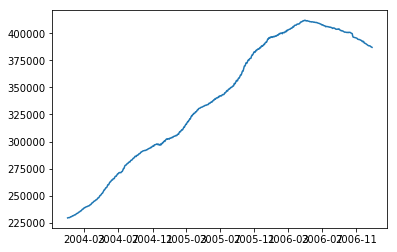

In [19]:
plt.plot(customers_stats["channel"]["Mail"]["total"])

dla porównania, wykres dla innego kanału dystrybucji

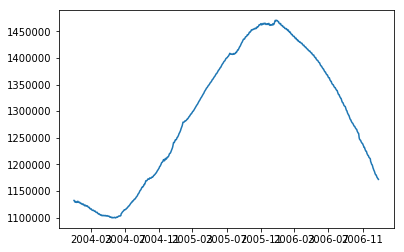

In [20]:
plt.plot(customers_stats["channel"]["Dealer"]["total"])

### zestawienie ogólne

grupowanie klientów, którzy przyszli lub odeszli w danym dniu

In [22]:
new_customers = df.groupby(["start_date"]).size()
retired_customers = df.groupby(["stop_date"]).size()
new_df = pd.DataFrame(new_customers)
retired_df = pd.DataFrame(retired_customers)
new_df.columns = ["new customers"]
new_df.index.name = "date"
retired_df.columns = ["retired customers"]
retired_df.index.name = "date"

### łączenie obu tabel

In [23]:
customer_stats_by_year = new_df.join(retired_df, how='outer')

### usunięcie danych lewostronnie uciętych
Obecnie nie mam pomysłu na wykorzystanie tych danych, choć wiem, że warto.

In [24]:
customer_stats_by_year.fillna(value=0, inplace=True)
customer_stats_by_year["active customers"] = customer_stats_by_year["new customers"] - customer_stats_by_year["retired customers"]
customer_stats_by_year["total"] = customer_stats_by_year["active customers"].cumsum()
customer = customer_stats_by_year[1:-1]

not_truncated = customer.loc['2004-01-01':]

## 4. Predykcja ilości klientów w przyszłości

### Dekompozycja przebiegów w celu wyciągnięcia trendu i sezonowości

In [28]:
res = sm.tsa.seasonal_decompose(not_truncated["total"], model='aditive', freq=30)

wyniki:

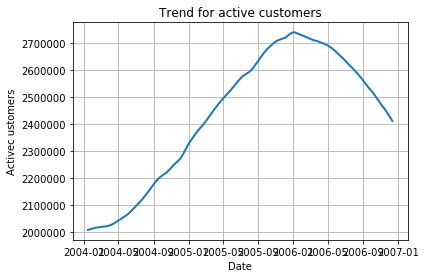

In [30]:
plt.plot(res.trend, lw=2)
plt.xlabel('Date')
plt.ylabel('Activec ustomers')
plt.title('Trend for active customers')
plt.grid(True)
plt.show()

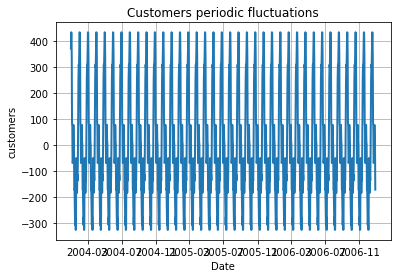

In [33]:
plt.plot(res.seasonal, lw=2)
plt.xlabel('Date')
plt.ylabel('customers')
plt.title('Customers periodic fluctuations')
plt.grid(True)
plt.show()

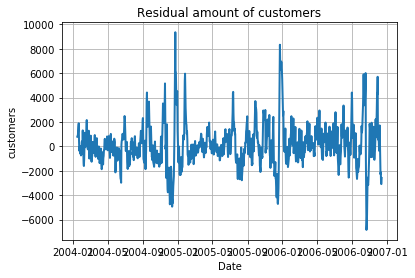

In [32]:
plt.plot(res.resid, lw=2)
plt.xlabel('Date')
plt.ylabel('customers')
plt.title('Residual amount of customers')
plt.grid(True)
plt.show()

### wykres autokorelacji danych

In [36]:
res.resid.dropna(inplace=True)
res.seasonal.dropna(inplace=True)

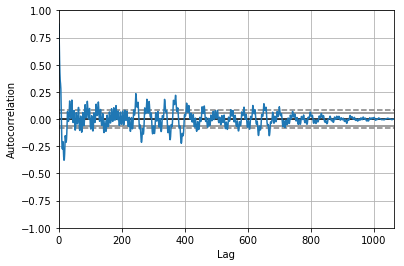

In [118]:
autocorrelation_plot(res.resid)

ACF, PACF

In [131]:
lag_acf = acf(res.resid, nlags=60)
lag_pacf = pacf(res.resid, nlags=60)

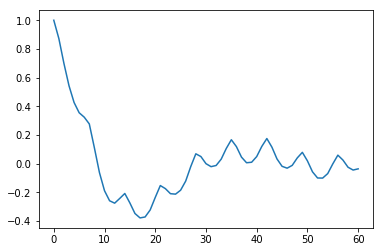

In [132]:
plt.plot(lag_acf)

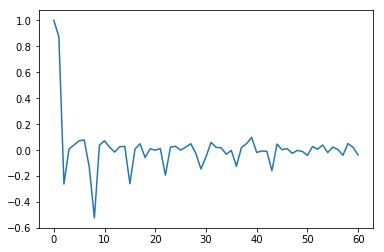

In [134]:
plt.plot(lag_pacf)

In [139]:
lag_acf[8]


0.11047867503223456

Test Ljung-Box

In [119]:
lb_test = dg.acorr_ljungbox(res.resid, lags=60)

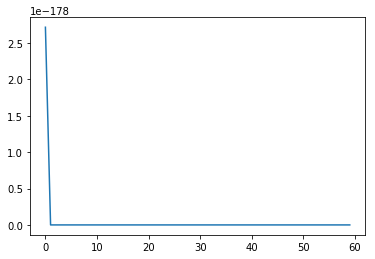

In [120]:
plt.plot(lb_test[1])

In [140]:
arima_model = ARIMA(endog=res.observed, order=(2,1,7))

In [141]:
mod = arima_model.fit()

/home/pwilkosz/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [142]:
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.total   No. Observations:                 1092
Model:                 ARIMA(2, 1, 7)   Log Likelihood               -8944.482
Method:                       css-mle   S.D. of innovations            872.099
Date:                Tue, 19 Dec 2017   AIC                          17910.963
Time:                        14:21:13   BIC                          17965.917
Sample:                    01-02-2004   HQIC                         17931.760
                         - 12-28-2006                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           313.6144    248.997      1.260      0.208    -174.410     801.639
ar.L1.D.total     0.4502      0.076      5.946      0.000       0.302       0.599
ar.L2.D.total     0.4938      0.076      6.524      0.000       0.345       0.642
ma.L1.D.total    -0.0824      0.072     -1.147      0.252      -0.223       0.058
ma.L2.D.total    -0.3900      0.054     -7.200      0.000      -0.496      -0.284
ma.L3.D.total    -0.1205      0.032     -3.753      0.000      -0.183      -0.058
ma.L4.D.total    -0.1302      0.033     -3.942      0.000      -0.195      -0.065
ma.L5.D.total    -0.1561      0.035     -4.504      0.000      -0.224      -0.088
ma.L6.D.total     0.0501      0.031      1.619      0.106      -0.011       0.111
ma.L7.D.total     0.3700      0.026     14.002      0.000       0.318       0.422
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0385           +0.0000j            1.0385            0.0000
AR.2           -1.9502           +0.0000j            1.9502            0.5000
MA.1            1.0681           -0.2942j            1.1079           -0.0428
MA.2            1.0681           +0.2942j            1.1079            0.0428
MA.3            0.2609           -1.1379j            1.1675           -0.2141
MA.4            0.2609           +1.1379j            1.1675            0.2141
MA.5           -0.8236           -0.8552j            1.1874           -0.3720
MA.6           -0.8236           +0.8552j            1.1874            0.3720
MA.7           -1.1461           -0.0000j            1.1461           -0.5000
-----------------------------------------------------------------------------
"""

In [143]:
mod.forecast()

(array([ 2389990.14208388]),
 array([ 872.09852761]),
 array([[ 2388280.86037879,  2391699.42378897]]))

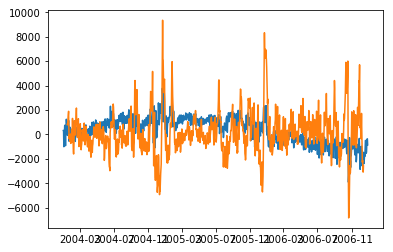

In [144]:
plt.plot(mod.fittedvalues)
plt.plot(res.resid)


In [154]:
predictions_ARIMA_diff = pd.Series(mod.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2004-01-02     313.614448
2004-01-03     243.501875
2004-01-04   -1014.222182
2004-01-05    -374.227389
2004-01-06      91.042197
dtype: float64

In [146]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [150]:
mod_preds = pd.Series(res.observed)

In [151]:
mod_preds = mod_preds.add(predictions_ARIMA_diff, fill_value=0)

In [188]:
pred_99 = mod.forecast(steps=1000, alpha=0.01)
pred_ci_99 = pred_99[2]

In [189]:
idx = pd.date_range(res.observed.index[-1], periods=1000)
fc_99 = pd.DataFrame(np.column_stack([pred_99[0], pred_ci_99]), 
                     index=idx, columns=['forecast', 'lower_ci_99', 'upper_ci_99'])
fc_99.head()

,forecast,lower_ci_99,upper_ci_99
2006-12-28,2.389990e+06,2.387744e+06,2.392237e+06
2006-12-29,2.389414e+06,2.385608e+06,2.393221e+06
2006-12-30,2.389015e+06,2.383722e+06,2.394307e+06
2006-12-31,2.388317e+06,2.381630e+06,2.395005e+06
2007-01-01,2.387783e+06,2.379844e+06,2.395721e+06


### rysowanie prognozy

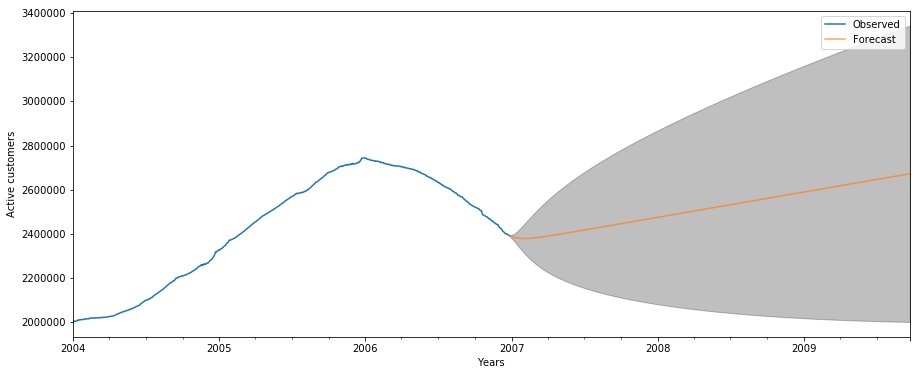

In [191]:
axis = res.observed.plot(label='Observed', figsize=(15, 6))
fc_99['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_99.index, fc_99['lower_ci_99'], fc_99['upper_ci_99'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Active customers')
plt.legend(loc='best')
plt.show()